## Data prep

In [6]:
SEQUENCE_LENGTH = 6

In [1]:
import pandas as pd
df = pd.read_csv("data/songdata.zip")
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [2]:
from pathlib import Path
import util

path = Path("chars.pkl")
chars = list()
if path.is_file():
    chars = util.load_vocab(path)
    print("Loaded from file")
else:
    vocab = set()
    for song in df["text"]:
        chars = set(song)
        vocab = vocab.union(chars)
    chars = list(vocab)
    util.write_vocab(path, chars)
    print("Generated from source")
    
vocab_size = len(chars)
print("Vocab size:", vocab_size)

Loaded from file
Vocab size: 76


In [3]:
char2idx = { char:i for i,char in enumerate(chars) }
idx2char = { i:char for i,char in enumerate(chars) }

In [4]:
def build_samples(song, buffer_length):
    tokens = song

    x_train = []
    y_train = []
    for i in range(0, len(song)):
        if i+buffer_length+1 >= len(tokens):
            continue
            
        x_train.append(tokens[i:i+buffer_length])
        y_train.append(tokens[i+buffer_length])

    return x_train,y_train

In [7]:
x_train, y_train = [], []
for song in df["text"][:500]:
    xs, ys = build_samples(song, SEQUENCE_LENGTH)
    x_train.extend(xs)
    y_train.extend(ys)
print("Training data length:", len(x_train))
print("X[0]:", x_train[0])
print("Y[0]:", y_train[0])

Training data length: 581323
X[0]: Look a
Y[0]: t


## Train/Test split

In [8]:
from sklearn.model_selection import train_test_split
import math

# 80% Train, 10% Dev, 10% Test
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2)
X_dev, X_test, Y_dev, Y_test = train_test_split(X_test, Y_test, test_size=0.5)

In [9]:
import numpy as np
from random import shuffle

def load_batch(xs, ys, begin, end):
    batch_size = end-begin
    
    x_train = np.zeros((batch_size, SEQUENCE_LENGTH, vocab_size))
    y_train = np.zeros((batch_size, vocab_size))
    
    xs_batch = xs[begin:end]
    ys_batch = ys[begin:end]
    
    c = list(zip(xs_batch, ys_batch))
    shuffle(c)
    xs_batch, ys_batch = zip(*c)
    
    for i in range(batch_size):
        x_train[i] = util.one_hot_encode_sequence(xs_batch[i], char2idx)
        y_train[i] = util.one_hot_encode(ys_batch[i], char2idx)
    
    return x_train, y_train

In [10]:
batches = util.generate_batches(len(X_train), 512)
begin, end = next(batches)
x_batch, y_batch = load_batch(X_train, Y_train, begin, end)
print(x_batch.shape, y_batch.shape)

(512, 6, 76) (512, 76)


In [13]:
decode_fn = lambda x: util.one_hot_decode(x, idx2char)
for i in range(10):
    xs = ''.join(util.decode_sequence(x_batch[i], decode_fn))
    y = util.one_hot_decode(y_batch[i], idx2char)
    print(f"{i} '{xs}' -> {y}")

0 'y way ' -> o
1 'urn ou' -> t
2 'never ' -> e
3 'tin'  ' -> 

4 ' life ' ->  
5 'e and ' -> y
6 '
Peopl' -> e
7 '
Until' ->  
8 'en you' ->  
9 '  
The' -> y


## Training time!

In [75]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, GRU
from keras.layers import LeakyReLU
from pathlib import Path
from keras.callbacks import Callback

weights_path = Path(f"weights_char_{SEQUENCE_LENGTH}.h5")

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

def build_model(vocab_size):
    model = Sequential()
    model.add(LSTM(512, input_shape=(SEQUENCE_LENGTH, vocab_size)))
    model.add(Dropout(0.2))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(vocab_size, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer="adam", metrics = ['accuracy'])
    return model

model = build_model(vocab_size)
if weights_path.is_file():
    print("Loaded!")
    model.load_weights(weights_path.resolve())
model.summary()

Loaded!
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 512)               1206272   
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 76)                38988     
Total params: 1,245,260
Trainable params: 1,245,260
Non-trainable params: 0
_________________________________________________________________


In [76]:
import math
batch_size = 256
history = LossHistory()

def generate_samples(batch_size):
    batches = util.generate_batches(len(X_train), batch_size)
    for begin, end in batches:
        x_batch, y_batch = load_batch(X_train, Y_train, begin, end)
        yield x_batch, y_batch
        
steps = math.ceil(len(X_train) / batch_size)
print("Number of batches:", steps)
model.fit_generator(generate_samples(batch_size), epochs=1, steps_per_epoch=steps, callbacks=[history])

Number of batches: 1817
Epoch 1/1
1817/1817 [==============================] - 87s 48ms/step - loss: 1.2881 - accuracy: 0.6163


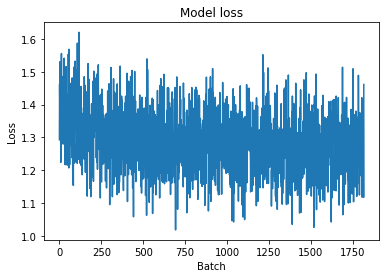

In [77]:
import matplotlib.pyplot as plt
plt.plot(history.losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Batch')
plt.show()

In [78]:
model.save_weights(weights_path.resolve())

In [79]:
from sampler import CharacterSampler
sampler = CharacterSampler(model, chars, SEQUENCE_LENGTH)

In [82]:
print(''.join(sampler.sample("i like", 700)))

i like the  
Don't water  
I mive can't just nearly
ol of a dixiles  
Sapalate  
You'll be ender, He cam your destence everyande - ]
  
I was a felidacro  
But it's omentar  
And not she can to be dance (mancina, it if you always on the hirts ain't no blues  
Unnide minnis ufay I'resighcy, loss on the darkest don't seep insh pants  
'Cause we Hlay waiting for in  
Could me shine  
How must know thais crysouck no question, on you know  
Your pain  
  
I can takes gonna ssides cime beglast  
To the eccyou  
I ballyong too many thing des(some to say down in my head  
  
Believe in the world  
Does there about  
Hey her  
She's from the hearsed times you need you can I can't his gial  
In I can shigh,


In [69]:
perplexity = 0.0
for x, y in list(zip(X_dev, Y_dev))[:800]:
    enc_seq = util.one_hot_encode_sequence(x, char2idx).reshape(1, SEQUENCE_LENGTH, vocab_size)
    preds = model.predict(enc_seq)
    y_hat = idx2char[np.argmax(preds)]
    likelihood = preds[0][np.argmax(y)]
    perplexity += np.log2(likelihood)
perplexity = np.power(2, perplexity * -1/800)
print(perplexity)

2017.584247843636
